# Plot reactome pathways: PSPA

In [12]:
from katlas.pssm import *
from katlas.score import *
from katlas.data import *
from katlas.plot import *
from katlas.pathway import *
from katlas.utils import *
import pandas as pd,seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import time, random

## Data

In [13]:
pspa_info=pd.read_parquet('raw/pspa_path_info.parquet')
df=pd.read_parquet('raw/pspa_score_df.parquet')

In [14]:
thr_cols = ['S_thr','T_thr','Y_thr']
gene_cols = ['S_genes','T_genes','Y_genes']
cnt_cols = ['S_cnt','T_cnt','Y_cnt']
site_cols = ['S_sites','T_sites','Y_sites']

## Site pssms

In [4]:
human_site= Data.get_human_site()
seq_map = human_site.set_index('sub_site')['site_seq']

In [6]:
series=pspa_info.iloc[0]

In [7]:
def get_site_pssm(series):
    pssm_dict = {}
    count_dict={}
    for acceptor, sites in zip(['S','T','Y'],series[site_cols]):
        sites=list(sites)
        if sites:
            pssm = get_prob(seq_map[sites])
            key = series.name+'_'+acceptor
            pssm_dict[key] = pd.Series(flatten_pssm(pssm))
            count_dict[key]=len(sites)
    return pssm_dict,count_dict

In [8]:
pssm_out = {}
count_out = {}
for i,r in pspa_info.iterrows():
    pssms,counts = get_site_pssm(r)
    pssm_out.update(pssms)
    count_out.update(counts)
    # break

In [9]:
site_pssms = pd.DataFrame(pssm_out).T

In [11]:
pspa_info.index[314:]

Index(['MATK', 'DDR1', 'DDR2', 'EGFR', 'EPHA1', 'EPHA2', 'EPHA3', 'EPHA4',
       'EPHA5', 'EPHA6', 'EPHA7', 'EPHA8', 'EPHB1', 'EPHB2', 'EPHB3', 'EPHB4',
       'BMX', 'PTK2', 'FER', 'FES', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'FGR',
       'FLT3', 'FRK', 'FYN', 'HCK', 'ERBB2', 'ERBB4', 'IGF1R', 'INSR', 'INSRR',
       'ITK', 'JAK1', 'JAK2', 'JAK3', 'KIT', 'LCK', 'LIMK1_TYR', 'LIMK2_TYR',
       'LTK', 'LYN', 'MERTK', 'MET', 'MAP2K4_TYR', 'MAP2K6_TYR', 'MAP2K7_TYR',
       'MST1R', 'MUSK', 'PKMYT1_TYR', 'NEK10_TYR', 'PDGFRA', 'PDGFRB',
       'PDHK1_TYR', 'PDHK3_TYR', 'PDHK4_TYR', 'PINK1_TYR', 'PTK2B', 'RET',
       'ROS1', 'SRC', 'SRMS', 'SYK', 'TEC', 'TESK1_TYR', 'TEK', 'TNK1',
       'TNNI3K_TYR', 'NTRK1', 'NTRK2', 'NTRK3', 'TXK', 'TYK2', 'TYRO3', 'FLT1',
       'KDR', 'FLT4', 'WEE1_TYR', 'YES1', 'ZAP70'],
      dtype='object', name='kinase')

In [12]:
for k in tqdm(pspa_info.index,total=len(pspa_info)):
    k_pssms = site_pssms[site_pssms.index.str.contains(f'{k}_')]
    plot_logos(k_pssms,count_dict=count_out)
    path = prepare_path(f'fig/pspa/{k}/path/logo.svg')
    save_show(path)
    # break

100%|█████████████████████████████████████████████████████████████| 82/82 [06:25<00:00,  4.70s/it]


In [13]:
site_pssms.to_parquet('raw/pspa_site_pssm.parquet')

## Plot distribution

In [14]:
def plot_hist(df,
              kinase,
              sty_thr=None, # dict of thresholds per acceptor
              hue='acceptor'):
    
    "Plot histogram of a column (kinase). "
    
    plt.figure(figsize=(6,2))

    hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True,
              'palette':sty_color}
    
    sns.histplot(data=df,x=kinase,hue=hue,**hist_params)
    
    plt.xlabel('')
    plt.title(f'{kinase} score distribution')

    if sty_thr:
        for acceptor,thr in sty_thr.items():
            if thr is not None:
                plt.axvline(thr,color=sty_color[acceptor])

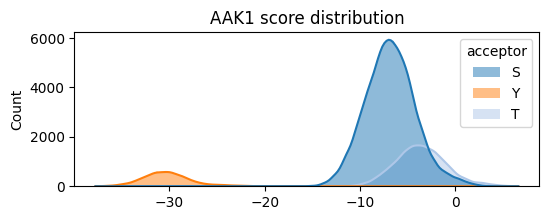

In [15]:
plot_hist(df,'AAK1')

In [18]:
for k,r in tqdm(pspa_info.iterrows(),total=len(pspa_info)):
    sty_thr=r[thr_cols].rename(index={'S_thr':'S','T_thr':'T','Y_thr':'Y'})[lambda x: x!=0].to_dict()
    plot_hist(df,k,sty_thr=sty_thr)
    save_show(f'fig/pspa/{k}/path/hist.svg',show_only=False)

100%|███████████████████████████████████████████████████████████| 396/396 [04:01<00:00,  1.64it/s]


## Plot reactome pathway

In [4]:
info = Data.get_kinase_info()

In [5]:
info = info[info.pseudo=='0']

In [6]:
info.uniprot.duplicated().sum()

np.int64(0)

In [7]:
kinase_map = info.set_index('kinase')['uniprot']

In [8]:
def get_path(series):
    out = get_reactome(series['genes'],p_type='p')
    kinase=series.name.split('_')[0] # for those with _TRY, need to remove that
    uniprot = kinase_map[kinase]
    out = add_reactome_ref(out,uniprot)
    exclude=['GTPase','SUMO']
    out = out[~out.name.str.contains('|'.join(exclude))]
    return out

In [9]:
show_only=False

In [19]:
pspa_info.index.get_loc('PKG1')

234

In [47]:
len(pspa_info)

396

In [20]:
for i,(k,r) in enumerate(pspa_info.iloc[234:].iterrows()):
    print(i,':',k)
    save_dir = f'fig/pspa/{k}/path'
    
    path_df = get_path(r)
    path_df.to_parquet(f'{save_dir}/path.parquet')

    plot_path(path_df,p_type='p',ref_col='ref_path',top_n=15,max_label_length=55)
    plt.title('Reactome pathways of substrates based on scores')
    save_show(f'{save_dir}/path.svg',show_only=show_only)

    if path_df.ref_path.sum()!=0:
        accuracy = get_overlap(path_df, ref_col='ref_path',plot=True,p_type='p',figsize=(5,3))
        plt.title(f'Distribution of –log₁₀(p) for reference pathways')
        save_show(f'{save_dir}/overlap.svg',show_only=show_only)

    if path_df.ref_path_lowest.sum()!=0:
        accuracy_lo = get_overlap(path_df, ref_col='ref_path_lowest',plot=True,p_type='p',figsize=(5,3))
        plt.title(f'Distribution of –log₁₀(p) for reference pathways \n(lowest-level)')
        save_show(f'{save_dir}/overlap_lo.svg',show_only=show_only)
    plt.close('all')
    # break
    
    # ✅ polite delay to avoid API throttling
    delay = random.uniform(1.5, 4)
    print(f"Sleeping {delay:.2f}s before next kinase...")
    time.sleep(delay)

0 : PKG1
Running pathway anlysis
Done
Sleeping 1.76s before next kinase...
1 : PKG2
Running pathway anlysis
Done
Sleeping 3.58s before next kinase...
2 : PKN1
Running pathway anlysis
Done
Sleeping 3.84s before next kinase...
3 : PKN2
Running pathway anlysis
Done
Sleeping 1.53s before next kinase...
4 : PKN3
Running pathway anlysis
Done
Sleeping 3.71s before next kinase...
5 : PKR
Running pathway anlysis
Done
Sleeping 2.22s before next kinase...
6 : PLK1
Running pathway anlysis
Done
Sleeping 2.26s before next kinase...
7 : PLK2
Running pathway anlysis
Done
Sleeping 3.69s before next kinase...
8 : PLK3
Running pathway anlysis
Done
Sleeping 3.72s before next kinase...
9 : PLK4
Running pathway anlysis
Done
Sleeping 2.47s before next kinase...
10 : PRKD1
Running pathway anlysis
Done
Sleeping 3.57s before next kinase...
11 : PRKD2
Running pathway anlysis
Done
Sleeping 3.49s before next kinase...
12 : PRKD3
Running pathway anlysis
Done
Sleeping 2.62s before next kinase...
13 : PRKX
Running pa

## Get accuracy for overlap pathways

In [21]:
acc_dict, num_dict = {}, {}
acc_lo_dict, num_lo_dict = {}, {}

for k,r in pspa_info.iterrows():
    save_dir = f'fig/pspa/{k}/path'
    
    path_df=pd.read_parquet(f'{save_dir}/path.parquet')

    if path_df.ref_path.sum()!=0:
        accuracy = get_overlap(path_df, ref_col='ref_path',plot=False,p_type='p')
        acc_dict[k] = accuracy
        num_dict[k] =path_df.ref_path.sum()

    if path_df.ref_path_lowest.sum()!=0:
        accuracy_lo = get_overlap(path_df, ref_col='ref_path_lowest',plot=False,p_type='p')
        acc_lo_dict[k] = accuracy_lo
        num_lo_dict[k] = path_df.ref_path_lowest.sum()
    # break

In [22]:
pspa_info['accuracy'] = acc_dict
pspa_info['accuracy_lowest'] = acc_lo_dict

pspa_info['path_num'] = num_dict
pspa_info['path_lowest_num'] = num_lo_dict

In [23]:
pspa_info['path_num'] = pspa_info['path_num'].fillna(0).astype(int)
pspa_info['path_lowest_num'] = pspa_info['path_lowest_num'].fillna(0).astype(int)

In [24]:
pspa_info.to_parquet('raw/pspa_path_info.parquet')

## Pathway hue

In [2]:
pspa_info=pd.read_parquet('raw/pspa_path_info.parquet')

In [3]:
def plot_path_hist(df,
              colname,
              **kwargs,
              ):
    
    "Plot histogram of a column (kinase). "
    
    plt.figure(figsize=(6,2))

    hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True,
              }
    
    sns.histplot(data=df,x=colname,**kwargs, **hist_params)
    
    plt.xlabel('')
    plt.title(f'Accuracy score distribution')

In [4]:
q75, q50 = pspa_info.path_num[lambda x: x!=0].quantile([0.75,0.5])
q75, q50

(33.75, 11.0)

In [5]:
def categorize_path_num(x):
    if x >= q75: return f'well known (≥{q75:.0f})'
    elif x <= q50: return f'less known (≤{q50:.0f})'
    else: return f'middle ({q50:.0f}–{q75:.0f})'

In [6]:
pspa_info['category'] = pspa_info['path_num'].apply(categorize_path_num)

In [7]:
pspa_info['category'].value_counts()

category
less known (≤11)    253
well known (≥34)     74
middle (11–34)       69
Name: count, dtype: int64

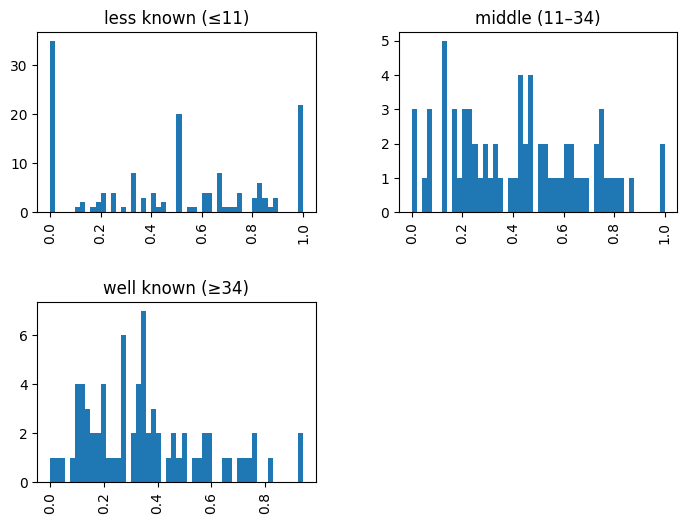

In [8]:
pspa_info.hist(column='accuracy', by='category', bins=50, figsize=(8,6));

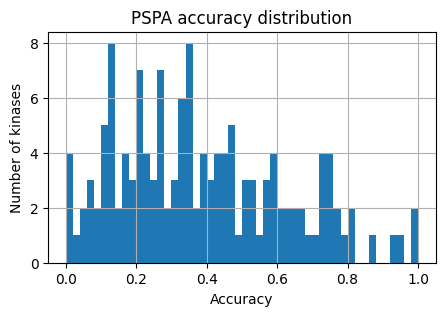

In [9]:
pspa_info[pspa_info.path_num>12].accuracy.hist(bins=50,figsize=(5,3))
plt.xlabel('Accuracy')
plt.ylabel('Number of kinases')
plt.title('PSPA accuracy distribution');

### Lowest

In [133]:
pspa_info.path_lowest_num[lambda x: x!=0].quantile([0.75])

0.75    10.0
Name: path_lowest_num, dtype: float64

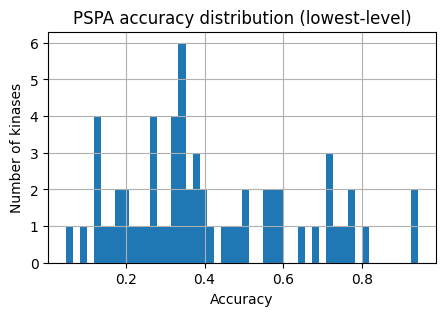

In [135]:
pspa_info[pspa_info.path_lowest_num>10].accuracy.hist(bins=50,figsize=(5,3))
plt.xlabel('Accuracy')
plt.ylabel('Number of kinases')
plt.title('PSPA accuracy distribution (lowest-level)');